# Улучшенный бенчмарк

Для задачи **Digital Reputation Challenge**

https://boosters.pro

автор: Дарья Соболева

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

%matplotlib inline

//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## загрузка данных

In [29]:
TRAIN_PATH = 'train/'
X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')
Y = pd.read_csv(TRAIN_PATH + 'Y.csv')
print (X1.shape, X2.shape, X3.shape, Y.shape)

(4000, 26) (462888, 2) (4000, 453) (4000, 6)


In [30]:
Y.columns = ['Y' + s if s != 'id' else 'id' for s in Y.columns]

In [31]:
TEST_PATH = 'test/'
X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')
print (X1_test.shape, X2_test.shape, X3_test.shape)

(4058, 26) (470083, 2) (4058, 453)


In [5]:
X2_all = pd.concat([X2, X2_test], axis=0)

X2_user_ids, X2_counts = np.unique(X2_all['id'], return_counts=True)
url_count = np.hstack((X2_user_ids.reshape(-1, 1), X2_counts.reshape(-1, 1)))
url_count_df = pd.DataFrame(data=url_count, columns=['id', 'Counter'])

X1 = X1.merge(url_count_df, on='id', how='left')
X1_test = X1_test.merge(url_count_df, on='id', how='left')

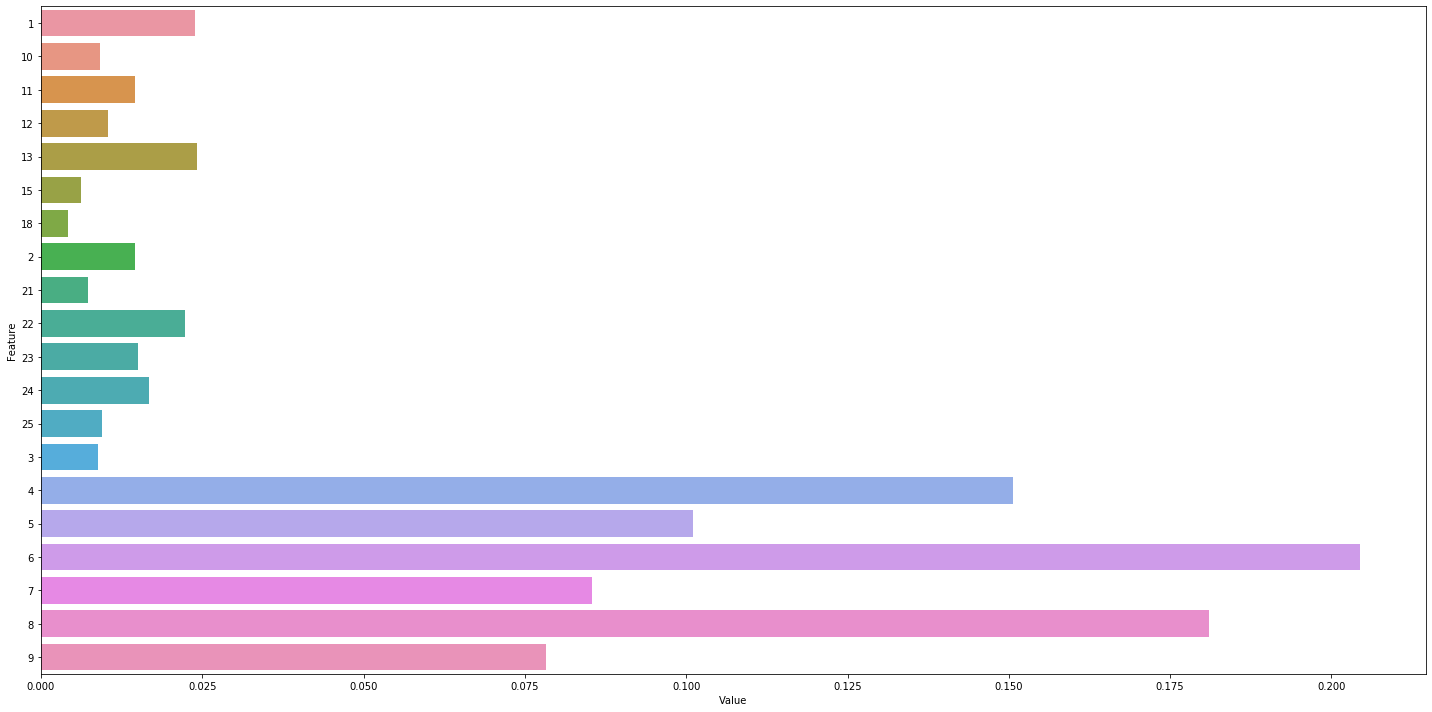

In [70]:
warnings.simplefilter(action='ignore', category=FutureWarning)

model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X1[X1.columns.difference(['id', 'Counter'])], y1)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X1.columns.difference(['id', 'Counter'])))[-20:], columns=['Value','Feature'])

feature_imp = feature_imp.sort_values(by="Value", ascending=False)


plt.figure(figsize=(20, 10))

sns.barplot(x="Value", y="Feature", data=feature_imp, orient='h')

plt.tight_layout()
plt.show()

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier

def get_and_plot_important_features(X, y, verbose=False, n=1):
    warnings.simplefilter(action='ignore', category=FutureWarning)

    model = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    model.fit(X[X.columns.difference(['id', 'Counter'])], y)

    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns.difference(['id', 'Counter'])))[-10:], columns=['Value','Feature'])

    feature_imp = feature_imp.sort_values(by="Value", ascending=False)
    
    if verbose:
        plt.figure(figsize=(20, 10))

        sns.barplot(x="Value", y="Feature", data=feature_imp, orient='h')

        plt.tight_layout()
        plt.show()
    #return [feature_imp.Feature.iloc[0]]
    return list(feature_imp.Feature[:n])
    

def stat_imp_features(imp_features, cls, X, X_test, f):
    X_all = pd.concat([X, X_test], axis=0)
    
    X_f_counts = X[f].value_counts().to_frame()
    X_f_counts = X_f_counts.reset_index()
    X_f_counts.columns = [f, 'Count']

    X_f_counts_filtered = X_f_counts[X_f_counts.Count > 25]
    cols = list(set(X1.columns) & set(imp_features1))
    X_merged = pd.merge(X[X.columns.difference(cols)], X_f_counts_filtered, how='right', on=f)
    X_merged = pd.merge(X_merged, X1[['id'] + imp_features], how='left', on='id')
    
    funcs = [np.mean, np.sum] # np.median#[np.mean, np.max, np.min, np.std]
    
    grouped_f = X_merged.groupby(f)

    X_all = X_all.set_index(f)
    
    print(cls)
    for imp_feature in imp_features:
        print(imp_feature)
        
        for func in funcs:
            #print(func.__name__)
            stat = grouped_f[imp_feature].apply(lambda x: func(x))
            #return X2_all, stat
            #print(func, imp_feature)
            X_all['{}_{}'.format(imp_feature, func.__name__)] = stat
        
    X_all = X_all.reset_index()
    grouped_id = X_all.groupby('id')
    
    res = X_all[['id']].drop_duplicates().set_index('id')
    imp_features1_list = []
    
    for imp_feature in imp_features:
        print(imp_feature)
        for func1 in funcs:
            for func2 in funcs:
                #print(imp_feature, func1.__name__, func2.__name__)
                stat_stat = grouped_id['{}_{}'.format(imp_feature, func1.__name__)].apply(lambda x: func2(x))
                f = '{}_{}_{}_{}_{}'.format(imp_feature, func1.__name__, func2.__name__, cls, f)
                res[f] = stat_stat
                imp_features1_list.append(f)
        
    return res.reset_index(), imp_features1_list
    
X = X1.merge(Y)

id_ = X.pop('id')
y1 = X.pop('Y1')
y2 = X.pop('Y2')
y3 = X.pop('Y3')
y4 = X.pop('Y4')
y5 = X.pop('Y5')

# model1 = lgb.LGBMClassifier(learning_rate=0.01, num_leaves=12,
#                             n_estimators=290,
#                             colsample_bytree=0.75, subsample=0.75, random_state=0, n_jobs=-1)

imp_features1 = get_and_plot_important_features(X, y1, verbose=False, n=3)
#imp_features1 += ['5', '7', '3', 'Counter']
statA_imp_features1, impA_features1 = stat_imp_features(imp_features1, 'Y1', X2, X2_test, 'A')

imp_features2 = get_and_plot_important_features(X, y2, verbose=False, n=3)
#imp_features2 += ['5', '7', '3', 'Counter']
statA_imp_features2, impA_features2 = stat_imp_features(imp_features2, 'Y2', X2, X2_test, 'A')

imp_features3 = get_and_plot_important_features(X, y3, verbose=False, n=3)
#imp_features3 += ['5', '7', '3', 'Counter']
statA_imp_features3, impA_features3 = stat_imp_features(imp_features3, 'Y3', X2, X2_test, 'A')

imp_features4 = get_and_plot_important_features(X, y4, verbose=False, n=3)
#imp_features4 += ['5', '7', '3', 'Counter']
statA_imp_features4, impA_features4 = stat_imp_features(imp_features4, 'Y4', X2, X2_test, 'A')

imp_features5 = get_and_plot_important_features(X, y5, verbose=False, n=3)
#imp_features5 += ['5', '7', '3', 'Counter']
statA_imp_features5, impA_features5 = stat_imp_features(imp_features5, 'Y5', X2, X2_test, 'A')



stat1_imp_features1, imp1_features1 = stat_imp_features(imp_features1, 'Y1', X1, X1_test, '1')
stat1_imp_features2, imp1_features2 = stat_imp_features(imp_features2, 'Y2', X1, X1_test, '1')
stat1_imp_features3, imp1_features3 = stat_imp_features(imp_features3, 'Y3', X1, X1_test, '1')
stat1_imp_features4, imp1_features4 = stat_imp_features(imp_features4, 'Y4', X1, X1_test, '1')
stat1_imp_features5, imp1_features5 = stat_imp_features(imp_features5, 'Y5', X1, X1_test, '1')

stat13_imp_features1, imp13_features1 = stat_imp_features(imp_features1, 'Y1', X1, X1_test, '13')
stat13_imp_features2, imp13_features2 = stat_imp_features(imp_features2, 'Y2', X1, X1_test, '13')
stat13_imp_features3, imp13_features3 = stat_imp_features(imp_features3, 'Y3', X1, X1_test, '13')
stat13_imp_features4, imp13_features4 = stat_imp_features(imp_features4, 'Y4', X1, X1_test, '13')
stat13_imp_features5, imp13_features5 = stat_imp_features(imp_features5, 'Y5', X1, X1_test, '13')

stat22_imp_features1, imp22_features1 = stat_imp_features(imp_features1, 'Y1', X1, X1_test, '22')
stat22_imp_features2, imp22_features2 = stat_imp_features(imp_features2, 'Y2', X1, X1_test, '22')
stat22_imp_features3, imp22_features3 = stat_imp_features(imp_features3, 'Y3', X1, X1_test, '22')
stat22_imp_features4, imp22_features4 = stat_imp_features(imp_features4, 'Y4', X1, X1_test, '22')
stat22_imp_features5, imp22_features5 = stat_imp_features(imp_features5, 'Y5', X1, X1_test, '22')

Y1
6
8
4
6
8
4
Y2
6
8
4
6
8
4
Y3
6
8
4
6
8
4
Y4
6
8
4
6
8
4
Y5
6
8
4
6
8
4
Y1
6
8
4
6
8
4
Y2
6
8
4
6
8
4
Y3
6
8
4
6
8
4
Y4
6
8
4
6
8
4
Y5
6
8
4
6
8
4
Y1
6
8
4
6
8
4
Y2
6
8
4
6
8
4
Y3
6
8
4
6
8
4
Y4
6
8
4
6
8
4
Y5
6
8
4
6
8
4
Y1
6
8
4
6
8
4
Y2
6
8
4
6
8
4
Y3
6
8
4
6
8
4
Y4
6
8
4
6
8
4
Y5
6
8
4
6
8
4


In [16]:
# filter on popularity

X2_all = X2.append(X2_test)

A_top_100 = X2_all.A.value_counts()[:20].to_frame()
A_top_100 = A_top_100.reset_index()
A_top_100.columns = ['A', 'count']

X2_top_100 = X2_all.merge(A_top_100, on='A', how='inner')
X2_top_100_dummies = pd.get_dummies(X2_top_100[['id', 'A']], columns=['A'])
X2_top_100_dummies = X2_top_100_dummies.groupby('id').sum().reset_index()

In [33]:
# filter on Y
def get_filtered_dummies(X2_Y, target):
    Y_A_count_class = X2_Y[X2_Y[target] == 1].groupby('A').size().to_frame()
    Y_A_count_class = Y_A_count_class.reset_index()
    Y_A_count_class.columns = ['A', 'count_class_1']
    Y_A_count_filtered = Y_A_count_class[Y_A_count_class.count_class_1 >= 25]

    Y_A_count = X2_Y.groupby('A').size().to_frame()
    Y_A_count = Y_A_count.reset_index()
    Y_A_count.columns = ['A', 'count']
    Y_A_count_filtered = Y_A_count_filtered.merge(Y_A_count, on='A', how='left')
    Y_A_count_filtered['ctr_count'] = Y_A_count_filtered['count_class_1'] / Y_A_count_filtered['count'] 


    A_top_100_left = Y_A_count_filtered.sort_values('ctr_count', ascending=False)[:30]
    A_top_100_right = Y_A_count_filtered.sort_values('ctr_count', ascending=False)[-30:]
    A_top_100 = pd.concat([A_top_100_left, A_top_100_right], axis=0)
    A_top_100 = A_top_100[['A', 'ctr_count']]

    X2_top_100 = X2.merge(A_top_100, on='A', how='inner')
    X2_top_100_dummies = pd.get_dummies(X2_top_100[['id', 'A']], columns=['A'], prefix_sep='_' + target + '_')
    X2_top_100_dummies = X2_top_100_dummies.groupby('id').sum().reset_index()
    
    X2_test_top_100 = X2_test.merge(A_top_100, on='A', how='inner')
    X2_test_top_100_dummies = pd.get_dummies(X2_test_top_100[['id', 'A']], columns=['A'], prefix_sep='_' + target + '_')
    X2_test_top_100_dummies = X2_test_top_100_dummies.groupby('id').sum().reset_index()
    
    features = list(X2_top_100_dummies.columns.difference(['id']))
    return X2_top_100_dummies, X2_test_top_100_dummies, features
    
X2_Y = X2.merge(Y, how='left', on='id')

X2_top_100_dummies1, X2_test_top_100_dummies1, features1 = get_filtered_dummies(X2_Y, 'Y1')
X2_top_100_dummies2, X2_test_top_100_dummies2, features2 = get_filtered_dummies(X2_Y, 'Y2')
X2_top_100_dummies3, X2_test_top_100_dummies3, features3 = get_filtered_dummies(X2_Y, 'Y3')
X2_top_100_dummies4, X2_test_top_100_dummies4, features4 = get_filtered_dummies(X2_Y, 'Y4')
X2_top_100_dummies5, X2_test_top_100_dummies5, features5 = get_filtered_dummies(X2_Y, 'Y5')

In [6]:
# count user

X2_user_count = X2_all.id.value_counts().to_frame()
X2_user_count = X2_user_count.reset_index()
X2_user_count.columns = ['id', 'count']

# Подготовка обучения и теста

используем только матрицу 1

In [34]:
X = X1.copy()
base_features = list(X.columns.difference(['id']))

X = X.merge(statA_imp_features1, on='id', how='left')
X = X.merge(statA_imp_features2, on='id', how='left')
X = X.merge(statA_imp_features3, on='id', how='left')
X = X.merge(statA_imp_features4, on='id', how='left')
X = X.merge(statA_imp_features5, on='id', how='left')

X = X.merge(stat22_imp_features1, on='id', how='left')
X = X.merge(stat22_imp_features2, on='id', how='left')
X = X.merge(stat22_imp_features3, on='id', how='left')
X = X.merge(stat22_imp_features4, on='id', how='left')
X = X.merge(stat22_imp_features5, on='id', how='left')

X = X.merge(stat1_imp_features1, on='id', how='left')
X = X.merge(stat1_imp_features2, on='id', how='left')
X = X.merge(stat1_imp_features3, on='id', how='left')
X = X.merge(stat1_imp_features4, on='id', how='left')
X = X.merge(stat1_imp_features5, on='id', how='left')

X = X.merge(stat13_imp_features1, on='id', how='left')
X = X.merge(stat13_imp_features2, on='id', how='left')
X = X.merge(stat13_imp_features3, on='id', how='left')
X = X.merge(stat13_imp_features4, on='id', how='left')
X = X.merge(stat13_imp_features5, on='id', how='left')

X = X.merge(X2_top_100_dummies1, on='id', how='left')
X = X.merge(X2_top_100_dummies2, on='id', how='left')
X = X.merge(X2_top_100_dummies3, on='id', how='left')
X = X.merge(X2_top_100_dummies4, on='id', how='left')
X = X.merge(X2_top_100_dummies5, on='id', how='left')

X.fillna(0.0, inplace=True, axis=0)
#X = X.merge(X2_user_count, on='id', how='left')

X = X.merge(Y)

id_ = X.pop('id')
y1 = X.pop('Y1')
y2 = X.pop('Y2')
y3 = X.pop('Y3')
y4 = X.pop('Y4')
y5 = X.pop('Y5')

X_test = X1_test.copy()

X_test = X_test.merge(statA_imp_features1, on='id', how='left')
X_test = X_test.merge(statA_imp_features2, on='id', how='left')
X_test = X_test.merge(statA_imp_features3, on='id', how='left')
X_test = X_test.merge(statA_imp_features4, on='id', how='left')
X_test = X_test.merge(statA_imp_features5, on='id', how='left')

X_test = X_test.merge(stat22_imp_features1, on='id', how='left')
X_test = X_test.merge(stat22_imp_features2, on='id', how='left')
X_test = X_test.merge(stat22_imp_features3, on='id', how='left')
X_test = X_test.merge(stat22_imp_features4, on='id', how='left')
X_test = X_test.merge(stat22_imp_features5, on='id', how='left')

X_test = X_test.merge(stat1_imp_features1, on='id', how='left')
X_test = X_test.merge(stat1_imp_features2, on='id', how='left')
X_test = X_test.merge(stat1_imp_features3, on='id', how='left')
X_test = X_test.merge(stat1_imp_features4, on='id', how='left')
X_test = X_test.merge(stat1_imp_features5, on='id', how='left')

X_test = X_test.merge(stat13_imp_features1, on='id', how='left')
X_test = X_test.merge(stat13_imp_features2, on='id', how='left')
X_test = X_test.merge(stat13_imp_features3, on='id', how='left')
X_test = X_test.merge(stat13_imp_features4, on='id', how='left')
X_test = X_test.merge(stat13_imp_features5, on='id', how='left')

X_test = X_test.merge(X2_test_top_100_dummies1, on='id', how='left')
X_test = X_test.merge(X2_test_top_100_dummies2, on='id', how='left')
X_test = X_test.merge(X2_test_top_100_dummies3, on='id', how='left')
X_test = X_test.merge(X2_test_top_100_dummies4, on='id', how='left')
X_test = X_test.merge(X2_test_top_100_dummies5, on='id', how='left')

X_test.fillna(0.0, inplace=True, axis=0)

# X_test = X_test.merge(X2_user_count, on='id', how='left')

id__ = X_test.pop('id')

### Эксперименты

делаются так...

In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb


def colsample_fit(X_train, y_train, X_test, param, random_state):
    final_pred = []
    w = [0.4, 0.5, 0.7, 0.8, 0.9]
    for colsample_bytree in w:
        param['colsample_bytree'] = colsample_bytree
        estimator = lgb.LGBMClassifier(**param, n_jobs=-1, random_state=random_state)
        estimator.fit(X_train.values, y_train.values)
        pred_statement = estimator.predict_proba(X_test.values)[:, 1]
        final_pred.append(pred_statement)
        
    final_pred = np.sum(np.array(final_pred).T * np.array(w), axis=1) / np.sum(w)
    param['colsample_bytree'] = 0.75
    estimator = lgb.LGBMClassifier(**param, n_jobs=-1, random_state=random_state)
    estimator.fit(X_train.values, y_train.values)
    pred_statement = estimator.predict_proba(X_test.values)[:, 1]
    final_pred = (np.array(final_pred) + pred_statement) / 2.0
    return final_pred

def cv_default(param, X, y, n_splits=10, random_state=0):
    estimator = lgb.LGBMClassifier(**param, n_jobs=-1, random_state=random_state)
    
    cv = KFold(n_splits=n_splits, shuffle=False, random_state=random_state)
    cv_iter = list(cv.split(X, y))
    
    scores = []

    for train, test in cv_iter:
        estimator.fit(X.iloc[train, :].values, y.iloc[train].values)
        
        y_statement = y.iloc[test]
        pred_statement = estimator.predict_proba(X.iloc[test, :].values)[:, 1]
        
        #pred_statement = colsample_fit(X.iloc[train, :], y.iloc[train], X.iloc[test, :], param, random_state)
        scores.append(roc_auc_score(y_statement, pred_statement))
        
    return np.mean(np.array(scores))

def cv(param, X, y, nfold=50, random_state=0):
    w = lgb.cv(param, lgb.Dataset(X, label=y), stratified=False,
           num_boost_round=1000, nfold=nfold, seed=random_state) 
    return max(w['auc-mean'])

In [9]:
import lightgbm as lgb
import operator

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary', 
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75, 
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary', 
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary', 
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = {}
for num_leaves in list(range(4, 12, 2)) + list(range(12, 22, 2)):
    for colsample_bytree in [0.25, 0.5, 0.75, 1.0]:
        for subsample in [0.25, 0.5, 0.75, 1.0]:
            param1['num_leaves'] = num_leaves
            param1['colsample_bytree'] = colsample_bytree
            param1['subsample'] = subsample
            scores[(num_leaves, colsample_bytree, subsample)] = cv(param1, X[base_features+features1+impA_features1], y1)
    
best_param1 = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[0][0]
param1['num_leaves'],param1['colsample_bytree'],param1['subsample'] =  best_param1
print(param1)

scores = {}
for num_leaves in range(2, 22, 2):
    for colsample_bytree in [0.25, 0.5, 0.75, 1.0]:
        for subsample in [0.25, 0.5, 0.75, 1.0]:
            param2['num_leaves'] = num_leaves
            param2['colsample_bytree'] = colsample_bytree
            param2['subsample'] = subsample
            scores[(num_leaves, colsample_bytree, subsample)] = cv(param2, X[base_features+features2+impA_features2], y2)
    
best_param2 = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[0][0]
param2['num_leaves'],param2['colsample_bytree'],param2['subsample'] =  best_param2
print(param2)

scores = {}
for num_leaves in range(2, 22, 2):
    for colsample_bytree in [0.25, 0.5, 0.75, 1.0]:
        for subsample in [0.25, 0.5, 0.75, 1.0]:
            param3['num_leaves'] = num_leaves
            param3['colsample_bytree'] = colsample_bytree
            param3['subsample'] = subsample
            scores[(num_leaves, colsample_bytree, subsample)] = cv(param3, X[base_features+features3+impA_features3], y3)
    
best_param3 = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[0][0]
param3['num_leaves'],param3['colsample_bytree'],param3['subsample'] =  best_param3
print(param3)

scores = {}
for num_leaves in range(2, 22, 2):
    for colsample_bytree in [0.25, 0.5, 0.75, 1.0]:
        for subsample in [0.25, 0.5, 0.75, 1.0]:
            param4['num_leaves'] = num_leaves
            param4['colsample_bytree'] = colsample_bytree
            param4['subsample'] = subsample
            scores[(num_leaves, colsample_bytree, subsample)] = cv(param4, X[base_features+features4+impA_features4], y4)
    
best_param4 = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[0][0]
param4['num_leaves'],param4['colsample_bytree'],param4['subsample'] =  best_param4
print(param4)

scores = {}
for num_leaves in list(range(2, 22, 2)) + [3]:
    for colsample_bytree in [0.25, 0.5, 0.75, 1.0]:
        for subsample in [0.25, 0.5, 0.75, 1.0]:
            param5['num_leaves'] = num_leaves
            param5['colsample_bytree'] = colsample_bytree
            param5['subsample'] = subsample
            scores[(num_leaves, colsample_bytree, subsample)] = cv(param5, X[base_features+features5+impA_features5], y5)
    
best_param5 = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[0][0]
param5['num_leaves'],param5['colsample_bytree'],param5['subsample'] =  best_param5
print(param5)

scores = []
scores.append(cv(param1, X[base_features+features1+impA_features1], y1))
scores.append(cv(param2, X[base_features+features2+impA_features2], y2))
scores.append(cv(param3, X[base_features+features3+impA_features3], y3))
scores.append(cv(param4, X[base_features+features4+impA_features4], y4))
scores.append(cv(param5, X[base_features+features5+impA_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'n_estimators': 1000, 'num_leaves': 8, 'objective': 'binary', 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'subsample': 0.25, 'metric': 'auc'}
{'n_estimators': 1000, 'num_leaves': 4, 'objective': 'binary', 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'subsample': 0.25, 'metric': 'auc'}
{'n_estimators': 1000, 'num_leaves': 6, 'objective': 'binary', 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'subsample': 0.25, 'metric': 'auc'}
{'n_estimators': 1000, 'num_leaves': 2, 'objective': 'binary', 'learning_rate': 0.05, 'colsample_bytree': 0.25, 'subsample': 0.25, 'metric': 'auc'}
{'n_estimators': 1000, 'num_leaves': 3, 'objective': 'binary', 'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25, 'metric': 'auc'}
[0.6112750112833022, 0.5910309889576648, 0.6276192753967939, 0.596384531128654, 0.5632067605889531]
0.5979033134710736


In [50]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':8, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+impA_features1+imp22_features1+imp1_features1+imp13_features1], y1))
scores.append(cv(param2, X[base_features+features2+impA_features2+imp22_features2+imp1_features2+imp13_features2], y2))
scores.append(cv(param3, X[base_features+features3+impA_features3+imp22_features3+imp1_features3+imp13_features3], y3))
scores.append(cv(param4, X[base_features+features4+impA_features4+imp22_features4+imp1_features4+imp13_features4], y4))
scores.append(cv(param5, X[base_features+features5+impA_features5+imp22_features5+imp1_features5+imp13_features5], y5))

print(scores)
print(np.mean(scores))

[0.611167160375956, 0.6231362317196715, 0.6289643759321693, 0.6090848664491574, 0.5991151606187812]
0.6142935590191471


In [28]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':8, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 1.0, 'subsample': 0.25,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 1.0, 'subsample': 0.25,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 1.0, 'subsample': 0.25,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.25, 'subsample': 0.25,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.25,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+impA_features1], y1))
scores.append(cv(param2, X[base_features+features2+impA_features2], y2))
scores.append(cv(param3, X[base_features+features3+impA_features3], y3))
scores.append(cv(param4, X[base_features+features4+impA_features4], y4))
scores.append(cv(param5, X[base_features+features5+impA_features5], y5))

print(scores)
print(np.mean(scores))

[0.6151987165416142, 0.6255375497437743, 0.6294643818197097, 0.6110534107576142, 0.5978287230308484]
0.6158165563787121


In [20]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+impA_features1], y1))
scores.append(cv(param2, X[base_features+features2+impA_features2], y2))
scores.append(cv(param3, X[base_features+features3+impA_features3], y3))
scores.append(cv(param4, X[base_features+features4+impA_features4], y4))
scores.append(cv(param5, X[base_features+features5+impA_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6117147709189317, 0.6179712744598408, 0.6234963962092699, 0.6062505810001484, 0.5978287230308484]
0.6114523491238077


In [11]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+impA_features1+imp12_features1], y1))
scores.append(cv(param2, X[base_features+features2+impA_features2+imp12_features2], y2))
scores.append(cv(param3, X[base_features+features3+impA_features3+imp12_features3], y3))
scores.append(cv(param4, X[base_features+features4+impA_features4+imp12_features4], y4))
scores.append(cv(param5, X[base_features+features5+impA_features5+imp12_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6105549166519464, 0.6178046936747414, 0.6221297335708857, 0.6064613444070113, 0.596969515411341]
0.6107840407431852


In [10]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+imp_features1], y1))
scores.append(cv(param2, X[base_features+features2+imp_features2], y2))
scores.append(cv(param3, X[base_features+features3+imp_features3], y3))
scores.append(cv(param4, X[base_features+features4+imp_features4], y4))
scores.append(cv(param5, X[base_features+features5+imp_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6127034478161006, 0.6192508465619226, 0.6216391078656591, 0.6116328259008149, 0.5968473220520154]
0.6124147100393026


In [10]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+imp_features1], y1))
scores.append(cv(param2, X[base_features+features2+imp_features2], y2))
scores.append(cv(param3, X[base_features+features3+imp_features3], y3))
scores.append(cv(param4, X[base_features+features4+imp_features4], y4))
scores.append(cv(param5, X[base_features+features5+imp_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6130190380603134, 0.6232312248607247, 0.62373149578957, 0.6092623563089257, 0.5916564107714628]
0.6121801051581993


In [18]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+imp_features1], y1))
scores.append(cv(param2, X[base_features+features2+imp_features2], y2))
scores.append(cv(param3, X[base_features+features3+imp_features3], y3))
scores.append(cv(param4, X[base_features+features4+imp_features4], y4))
scores.append(cv(param5, X[base_features+features5+imp_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6117147709189317, 0.6179712744598408, 0.6234963962092699, 0.6062505810001484, 0.5978287230308484]
0.6114523491238077


In [10]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+imp_features1], y1))
scores.append(cv(param2, X[base_features+features2+imp_features2], y2))
scores.append(cv(param3, X[base_features+features3+imp_features3], y3))
scores.append(cv(param4, X[base_features+features4+imp_features4], y4))
scores.append(cv(param5, X[base_features+features5+imp_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6100815230545286, 0.6170958716713599, 0.6308808042155638, 0.603693786195624, 0.5931352309601315]
0.6109774432194416


In [9]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1+imp_features1], y1))
scores.append(cv(param2, X[base_features+features2+imp_features2], y2))
scores.append(cv(param3, X[base_features+features3+imp_features3], y3))
scores.append(cv(param4, X[base_features+features4+imp_features4], y4))
scores.append(cv(param5, X[base_features+features5+imp_features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6240259295741233, 0.6139571266389168, 0.6291637769388758, 0.6056379019508451, 0.5808878306542964]
0.6107345131514114


In [13]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X, y1))
scores.append(cv(param2, X, y2))
scores.append(cv(param3, X, y3))
scores.append(cv(param4, X, y4))
scores.append(cv(param5, X, y5))

print(scores)
print(np.mean(scores))

[0.6095421349473995, 0.5995572731129474, 0.6302295279036401, 0.6038930272663179, 0.5630446440530276]
0.6012533214566664


In [25]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':12, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X[base_features+features1], y1))
scores.append(cv(param2, X[base_features+features2], y2))
scores.append(cv(param3, X[base_features+features3], y3))
scores.append(cv(param4, X[base_features+features4], y4))
scores.append(cv(param5, X[base_features+features5], y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.6127615196443195, 0.607955257784282, 0.6285061161569343, 0.6008382052167156, 0.5635839587795958]
0.6027290115163695


In [9]:
import lightgbm as lgb

param1 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':1000, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':1000, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':1000, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':1000, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.05, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv(param1, X, y1))
scores.append(cv(param2, X, y2))
scores.append(cv(param3, X, y3))
scores.append(cv(param4, X, y4))
scores.append(cv(param5, X, y5))

print(scores)
print(np.mean(scores))

//anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[0.602379846937974, 0.5985401504911753, 0.6241238424504244, 0.6040459367879308, 0.5572908157669137]
0.5972761184868837


In [11]:
param1 = {'n_estimators':290, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param2 = {'n_estimators':378, 'num_leaves':2, 'objective':'binary',
         'learning_rate': 0.03, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param3 = {'n_estimators':543, 'num_leaves':4, 'objective':'binary',
         'learning_rate': 0.01, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param4 = {'n_estimators':618, 'num_leaves':6, 'objective':'binary',
         'learning_rate': 0.003, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

param5 = {'n_estimators':516, 'num_leaves':3, 'objective':'binary',
         'learning_rate': 0.002, 'colsample_bytree': 0.75, 'subsample': 0.75,
        'metric': 'auc'}

scores = []
scores.append(cv_default(param1, X, y1))
scores.append(cv_default(param2, X, y2))
scores.append(cv_default(param3, X, y3))
scores.append(cv_default(param4, X, y4))
scores.append(cv_default(param5, X, y5))

print(scores)
print(np.mean(scores))

[0.6106547050951469, 0.6018860071093031, 0.6169896178202073, 0.608072115564023, 0.5549038222792463]
0.5985012535735852


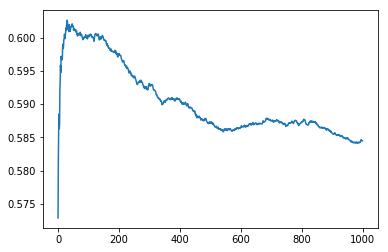

In [10]:
plt.plot(w['auc-mean'])

# Подготовка ответа

In [54]:
param1_final = param1.copy()
param1_final['n_estimators']= 290
param1_final['learning_rate'] = 0.01

a1 = 0.0
for t in range(10):
    model1 = lgb.LGBMClassifier(**param1_final, random_state=t, n_jobs=-1)
    model1.fit(X[base_features + features1 + impA_features1+imp22_features1+imp1_features1+imp13_features1], y1)
    a = model1.predict_proba(X_test[base_features + features1 + impA_features1+imp22_features1+imp1_features1+imp13_features1])[:,1]
    # print (a)
    a1 += a
a1 = a1 / 10

In [55]:
param2_final = param1.copy()
param2_final['n_estimators']= 378
param2_final['learning_rate'] = 0.03

a2 = 0.0
for t in range(10):
    model2 = lgb.LGBMClassifier(**param2_final, random_state=t, n_jobs=-1)
    model2.fit(X[base_features + features2 + impA_features2+imp22_features2+imp1_features2+imp13_features2], y2)
    a = model2.predict_proba(X_test[base_features + features2 + impA_features2+imp22_features2+imp1_features2+imp13_features2])[:,1]
    a2 += a
a2 = a2 / 10

In [56]:
param3_final = param1.copy()
param3_final['n_estimators']= 543
param3_final['learning_rate'] = 0.01

a3 = 0.0
for t in range(10):
    model3 = lgb.LGBMClassifier(**param3_final, random_state=t, n_jobs=-1)
    model3.fit(X[base_features + features3 + impA_features3+imp22_features3+imp1_features3+imp13_features3], y3)
    a = model3.predict_proba(X_test[base_features + features3 + impA_features3+imp22_features3+imp1_features3+imp13_features3])[:,1]
    a3 += a
a3 = a3 / 10

In [57]:
param4_final = param1.copy()
param4_final['n_estimators']= 618
param4_final['learning_rate'] = 0.003

a4 = 0.0
for t in range(10):
    model4 = lgb.LGBMClassifier(**param4_final, random_state=t, n_jobs=-1)
    model4.fit(X[base_features + features4 + impA_features4+imp22_features4+imp1_features4+imp13_features4], y4)
    a = model4.predict_proba(X_test[base_features + features4 + impA_features4+imp22_features4+imp1_features4+imp13_features4])[:,1]
    a4 += a
a4 = a4 / 10

In [58]:
param5_final = param1.copy()
param5_final['n_estimators']= 516
param5_final['learning_rate'] = 0.002

a5 = 0.0
for t in range(10):
    model5 = lgb.LGBMClassifier(**param5_final, random_state=t, n_jobs=-1)
    model5.fit(X[base_features + features5 + impA_features5+imp22_features5+imp1_features5+imp13_features5], y5)
    a = model5.predict_proba(X_test[base_features + features5 + impA_features5+imp22_features5+imp1_features5+imp13_features5])[:,1]
    #print (a)
    a5 += a
a5 = a5 / 10

In [59]:
df = pd.DataFrame({'id': X1_test.id.values,
             '1': a1,
             '2': a2,
             '3': a3,
             '4': a4,
             '5': a5})
df.to_csv('with_1_22_13_prev_colsample_0.75.csv', index=False)
df.head()

,id,1,2,3,4,5
0,0,0.363210,0.205448,0.241331,0.276296,0.467333
1,1,0.311129,0.117546,0.303775,0.253816,0.428307
2,2,0.398452,0.365771,0.227431,0.254291,0.396635
3,4,0.268858,0.217250,0.238411,0.252173,0.443656
4,7,0.343752,0.128236,0.566166,0.300778,0.401555
